<a href="https://colab.research.google.com/github/moey920/Object-Detection/blob/master/Detectron2_training(complete).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2. Detectron2 설치하기

In [1]:
# 종속 패키지(dependencies) 설치, 설치후에 Restart Runtime이 나오면 클릭해줍니다.
!pip install -U torch torchvision cython
!pip install -U 'git+https://github.com/facebookresearch/fvcore.git' 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
torch.__version__

Requirement already up-to-date: torch in /usr/local/lib/python3.6/dist-packages (1.4.0)
Requirement already up-to-date: torchvision in /usr/local/lib/python3.6/dist-packages (0.5.0)
Requirement already up-to-date: cython in /usr/local/lib/python3.6/dist-packages (0.29.15)
  Cloning https://github.com/facebookresearch/fvcore.git to /tmp/pip-req-build-q4lbtpy7
  Running command git clone -q https://github.com/facebookresearch/fvcore.git /tmp/pip-req-build-q4lbtpy7
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-yn969vod
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-yn969vod
     |████████████████████████████████| 276kB 39.6MB/s 
  Created wheel for fvcore: filename=fvcore-0.1-cp36-none-any.whl size=39765 sha256=94d6870baa4bcd30f61c3e4452eea0710fc5740fa086b024f4b1fabf46492fe4
  Stored in directory: /tmp/pip-ephem-wheel-cache-sq98kvy6/wheels/48/53/79/3c6485543a4455a0006f5db590ab9957622b6227011941de06
  Created wheel 

'1.4.0'

In [2]:
# Detectiorn2 repo 클론, 인스톨
!git clone https://github.com/facebookresearch/detectron2 detectron2_repo
!pip install -e detectron2_repo

Cloning into 'detectron2_repo'...
remote: Enumerating objects: 36, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 3112 (delta 6), reused 11 (delta 5), pack-reused 3076
Receiving objects: 100% (3112/3112), 2.10 MiB | 1.32 MiB/s, done.
Resolving deltas: 100% (2097/2097), done.
Obtaining file:///content/detectron2_repo
     |████████████████████████████████| 61kB 9.3MB/s 
  Found existing installation: tqdm 4.28.1
    Uninstalling tqdm-4.28.1:
      Successfully uninstalled tqdm-4.28.1
  Running setup.py develop for detectron2


In [0]:
# 인스톨이 완료되면 Colab Runtime을 다시 시작해주세요. 

# 기본 설정
# detectron2 logger 설정
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# 자주 사용하는 라이브러리 임폴트
import numpy as np
import cv2
import random
import os
from google.colab.patches import cv2_imshow

# 자주 사용하는 detectron2 유틸 임폴트 
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

# 1. Google Drive Api

In [0]:
# Google Drive api 활용, PyDrive package 인스톨
!pip install -U -q PyDrive

In [0]:
# Auth 승인을 받습니다. 코드 실행 시 링크가 나오면 들어가서 계정을 인증하고 인증 코드를 복사해 붙여넣습니다.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
   
# PyDrive Authentication
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# Folder Id로 FileList 받아오기
# 폴더 ID는 개인 드라이브에서 폴더에 들어가면 https://drive.google.com/drive/folders/ 이후에 나오는 주소입니다.

folder_id = '1R4bFN-68jn0Ug-gX4nWYTV0C87x6QN_2'
   
def ListFolder(parent):
    filelist=[]
    file_list = drive.ListFile({'q': "'%s' in parents and trashed=false" % parent}).GetList()
    for f in file_list:
        if f['mimeType']=='application/vnd.google-apps.folder': # if folder
            filelist.append({"id":f['id'],"title":f['title'],"list":ListFolder(f['id'])})
        else:
            filelist.append({"title":f['title'],"id":f['id']})
    return filelist
   
   
file_lists = ListFolder(folder_id)

In [0]:
# Local (colaboratory) directory 지정
# choose a local (colab) directory to store the data.
import os

local_download_path = os.path.expanduser('')
try:
	os.makedirs(local_download_path)
except: pass

In [6]:
# Filename 저장, 여기까지 하면 구글 드라이브 폴더 내의 파일을 Colab에 지정한 장소에 업로드 됩니다.
ret = []
for file in file_lists:
    print('title: %s, id: %s' % (file['title'], file['id']))
    fname = os.path.join(local_download_path, file['title'])
    print('downloading to {}'.format(fname))
    f_ = drive.CreateFile({'id': file['id']})
    f_.GetContentFile(fname)
    print(fname)
    ret.append(fname)

title: dataset.zip, id: 1zJScCWxOHfk0vRLnLGM6xRpTQiUKyGWw
downloading to dataset.zip
dataset.zip


In [7]:
#import os
#os.chdir('receipt')
!ls

adc.json  dataset.zip  detectron2_repo	sample_data


In [0]:
# 업로드한 파일을 압축해제합니다.
!unzip dataset.zip > /dev/null

In [8]:
#os.chdir('../')
!ls

adc.json  dataset.zip  detectron2_repo	sample_data  train  val


# 커스텀 데이터셋 학습하기

In [0]:
 # JSON 이 COCO 형식이 아닐 때 사용하세요.
#import os
#import numpy as np
#import json
#from detectron2.structures import BoxMode
#import itertools
#import cv2

# detectron2에서 데이터셋 정보를 로드하는 형식에 맞춰 함수를 작성합니다.
#def get_receipt_dicts(img_dir):
#    json_file = os.path.join(img_dir, "receipt_coco.json")
#    with open(json_file) as f:
#        imgs_anns = json.load(f)
#
#    dataset_dicts = []
#    for idx, v in enumerate(imgs_anns.values()):
#        record = {}
#        
#        filename = os.path.join(img_dir, v["file_name"])
#        height, width = cv2.imread(filename).shape[:2]
#        
#        record["file_name"] = filename
#        record["image_id"] = idx
#        record["height"] = height
#        record["width"] = width
#      
#        annos = v["regions"]
#        objs = []
#        for _, anno in annos.items():
#            assert not anno["region_attributes"]
#            anno = anno["shape_attributes"]
#            px = anno["all_points_x"]
#            py = anno["all_points_y"]
#            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
#            poly = list(itertools.chain.from_iterable(poly))
#
#            obj = {
#                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
#                "bbox_mode": BoxMode.XYXY_ABS,
#                "segmentation": [poly],
#                "category_id": 0,
#                "iscrowd": 0
#            }
#            objs.append(obj)
#        record["annotations"] = objs
#        dataset_dicts.append(record)
#    return dataset_dicts
#
#from detectron2.data import DatasetCatalog, MetadataCatalog
#for d in ["train", "val"]:
#    DatasetCatalog.register("receipt_" + d, lambda d=d: get_balloon_dicts("receipt/" + d))
#    MetadataCatalog.get("receipt_" + d).set(thing_classes=["receipt"])
#receipt_metadata = MetadataCatalog.get("receipt_train")

In [0]:
#from detectron2.data import DatasetCatalog, MetadataCatalog
#for d in ["train", "val"]:
#    DatasetCatalog.register("balloon_" + d, lambda d=d: get_balloon_dicts("balloon/" + d))
#    MetadataCatalog.get("balloon_" + d).set(thing_classes=["balloon"])
#balloon_metadata = MetadataCatalog.get("balloon_train")

In [0]:
# 인스톨이 완료되면 Colab Runtime을 다시 시작해주세요. 

# 기본 설정
# detectron2 logger 설정
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# 자주 사용하는 라이브러리 임폴트
import numpy as np
import cv2
import random
import os
from google.colab.patches import cv2_imshow
import matplotlib
import json

# 자주 사용하는 detectron2 유틸 임폴트 
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

In [0]:
import os
import numpy as np
import json
from detectron2.structures import BoxMode
import itertools
import cv2

def get_receipt_dicts(img_path,json_path):
    '''
    AD Oct 2019 : loading function to calculate the bboxes from the masks (as it does not exist so far in Detectron2)
    expected format:
    
    {'file_name': 'path/to/image',
    'height' : imgheight,
    'width': imgwidth,
    'annotations':
    [{'bbox': [xmin,ymin,xmax,ymax], 'bbox_mode': <BoxMode.XYXY_ABS: 0>,
    'segmentation': [[polygon/coordinates/x/y]],
    'category_id': 0, 'iscrowd': 0}, 
    {'bbox': [xmin2,ymin2,xmax2,ymax2], 'bbox_mode': <BoxMode.XYXY_ABS: 0>,
    'segmentation': [[polygon2/coordinates/x/y]],
    'category_id': 0, 'iscrowd': 0},
    
    etc ...]
    
    }
    INPUTS:
        img_path . str, path to the images
        json_path. str, path to the json annotation file (coco format)
    
    '''
    
    with open(json_path) as f:
        imgs_anns = json.load(f)
    dataset_dicts = []
    
    for img in imgs_anns['images']:
        record = {}
        
        filename = os.path.join(img_path,img['file_name'])
        height, width = cv2.imread(filename).shape[:2]
        image_id = img['id']

        record["file_name"] = filename
        record["height"] = height
        record["width"] = width
        
        for annos in imgs_anns['annotations']:
            if annos['image_id'] == image_id:

                objs = []
                poly = annos['segmentation']
                 
                for p in poly:
                    bbox=[]
                    x, y = p[::2] , p[1::2]
                    bbox.append(np.min(x))
                    bbox.append(np.min(y))
                    bbox.append(np.max(x))
                    bbox.append(np.max(y))
                    obj = {"bbox": bbox,
                            "bbox_mode": BoxMode.XYXY_ABS,
                            "segmentation": [p],
                            "category_id": 0,
                            "iscrowd": 0}
                    objs.append(obj)

        
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.data.datasets import register_coco_instances

register_coco_instances("train", {}, "train/receipt_coco.json",
                        "train/")

register_coco_instances("val", {}, "val/receipt_coco.json",
                        "val/")

receipt_metadata_train = MetadataCatalog.get("train")
receipt_metadata_val = MetadataCatalog.get("val")

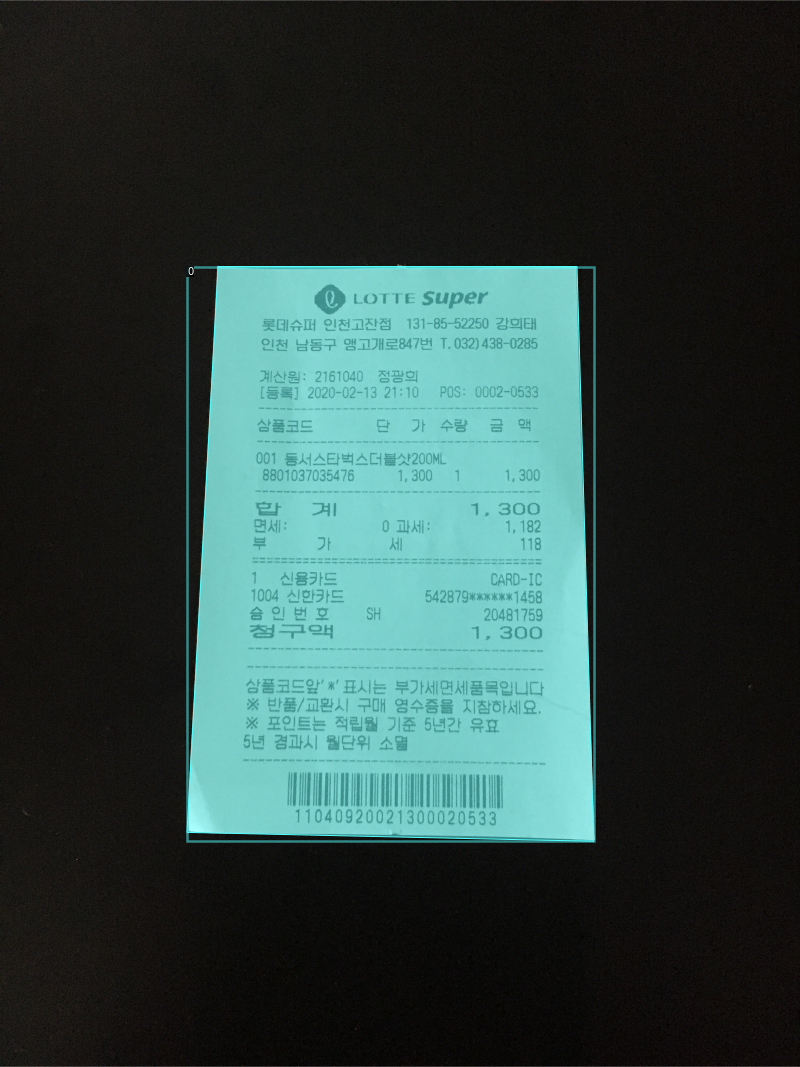

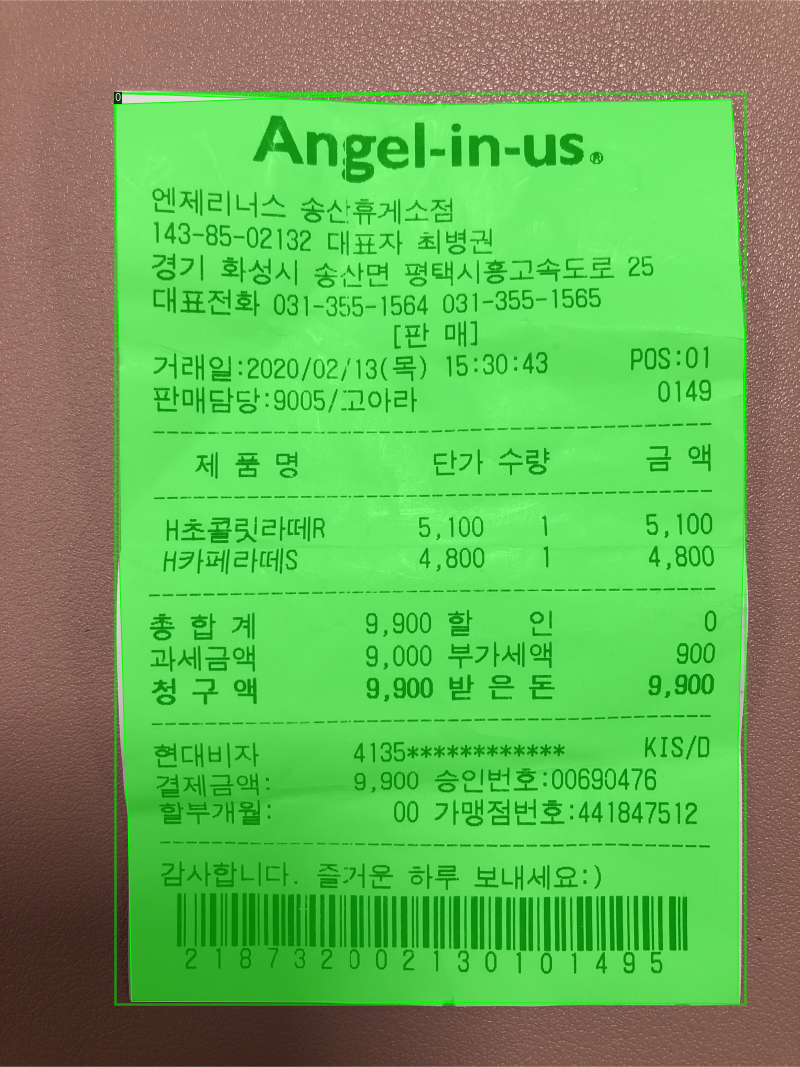

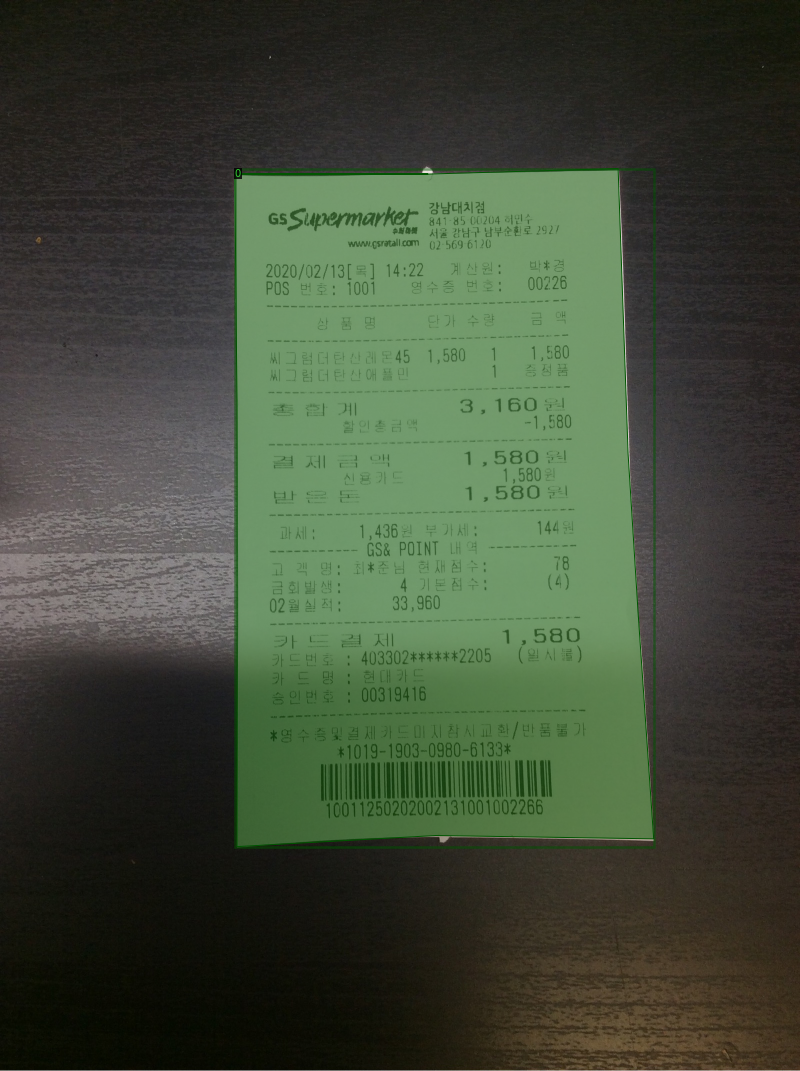

In [3]:
dataset_dicts = get_receipt_dicts("train","train/receipt_coco.json")
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], receipt_metadata_train, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

# 학습하기

In [4]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file("./detectron2_repo/configs/COCO-Detection/retinanet_R_50_FPN_3x.yaml")
cfg.DATASETS.TRAIN = ("train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl"   # initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 300    # 300 iterations 정도면 충분합니다. 더 오랜 시간도 시도해보세요.
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # 풍선 데이터셋과 같이 작은 데이터셋에서는 이정도면 적당합니다.
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # 클래스는 "풍선" 클래스 하나 뿐입니다.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

Loading config ./detectron2_repo/configs/COCO-Detection/../Base-RetinaNet.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


[02/24 00:53:47 d2.engine.defaults]: Model:
RetinaNet(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2)

[02/24 00:53:49 d2.engine.train_loop]: Starting training from iteration 0
[02/24 00:54:04 d2.utils.events]:  eta: 0:03:24  iter: 19  total_loss: 2.049  loss_cls: 1.557  loss_box_reg: 0.488  time: 0.7155  data_time: 0.0323  lr: 0.000005  max_mem: 3793M
[02/24 00:54:18 d2.utils.events]:  eta: 0:03:07  iter: 39  total_loss: 2.040  loss_cls: 1.560  loss_box_reg: 0.474  time: 0.7112  data_time: 0.0047  lr: 0.000010  max_mem: 3793M
[02/24 00:54:33 d2.utils.events]:  eta: 0:02:55  iter: 59  total_loss: 2.088  loss_cls: 1.587  loss_box_reg: 0.492  time: 0.7123  data_time: 0.0045  lr: 0.000015  max_mem: 3793M
[02/24 00:54:47 d2.utils.events]:  eta: 0:02:40  iter: 79  total_loss: 2.097  loss_cls: 1.602  loss_box_reg: 0.486  time: 0.7094  data_time: 0.0045  lr: 0.000020  max_mem: 3793M
[02/24 00:55:01 d2.utils.events]:  eta: 0:02:25  iter: 99  total_loss: 2.112  loss_cls: 1.652  loss_box_reg: 0.468  time: 0.7112  data_time: 0.0055  lr: 0.000025  max_mem: 3793M
[02/24 00:55:15 d2.utils.events]:  e